<a href="https://colab.research.google.com/github/WorldEconomist/Projects/blob/main/Machine%20Learning/nlp_sentiment_analysis_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1d2eUDZy1aovgj_s8hdJ_tehNGJy1GR3V

Downloading...
From: https://drive.google.com/uc?id=1d2eUDZy1aovgj_s8hdJ_tehNGJy1GR3V
To: /content/news_sentiment_analysis.csv
100% 2.15M/2.15M [00:00<00:00, 78.5MB/s]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

plt.style.use('dark_background')

In [3]:
df = pd.read_csv('news_sentiment_analysis.csv',
                 parse_dates = ['Published At'],
                 date_format = 'ISO8601')

In [4]:
df.head(3)

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12 23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12 22:59:42+00:00,neutral,Business
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12 22:52:55+00:00,positive,Business


#EDA and Data Preprocessing

In [5]:
df['Published At'] = pd.to_datetime(df['Published At'].dt.date)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Source        3500 non-null   object        
 1   Author        2512 non-null   object        
 2   Title         3500 non-null   object        
 3   Description   3500 non-null   object        
 4   URL           3500 non-null   object        
 5   Published At  3500 non-null   datetime64[ns]
 6   Sentiment     3500 non-null   object        
 7   Type          3500 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 218.9+ KB


As you can see, our classes are unbalanced, we might have to use oversampling in order to balance dataset

In [7]:
df['Sentiment'].value_counts(normalize = True)

,proportion
Sentiment,
positive,0.609714
neutral,0.225429
negative,0.164857


In [8]:
df['Type'].value_counts(normalize = True)

,proportion
Type,
Business,0.142857
Entertainment,0.142857
General,0.142857
Health,0.142857
Science,0.142857
Sports,0.142857
Technology,0.142857


In [9]:
df[['Source', 'Author']].nunique()

,0
Source,503
Author,816


In [10]:
sentiment_labels = df['Sentiment']
types = df[['Type']]

In [11]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(sentiment_labels)

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [13]:
encoded_types = ohe.fit_transform(types)

In [14]:
ohe_df = pd.DataFrame(encoded_types.toarray(),
                      columns = ohe.get_feature_names_out())

data = pd.concat([df, ohe_df],
                 axis=1).drop(['Type'],
                              axis=1)

data['Sentiment'] = encoded_labels

We'll combine Title and Description columns as each might contain paramount words

In [15]:
data['Сombined_description'] = data['Title'] + " " + data['Description']

data.drop(['Title', 'Description'], axis=1, inplace=True)

Let's carry out a text preprocessing and form words' lemmas in order to optimize following vectorization

In [16]:
def text_process(text):

  cleaned_text = re.sub(r'[^\w\s]|[\d]',
                          '',
                          text.lower())

  tokens = word_tokenize(cleaned_text)
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens
                     if word not in stop_words]

  Lemmatizer = WordNetLemmatizer()
  Lemmatized_tokens = [Lemmatizer.lemmatize(word) for word in filtered_tokens]

  processed_text = ' '.join(Lemmatized_tokens)

  return processed_text

In [17]:
data['Сombined_description'] = data['Сombined_description'].map(text_process)
description = data['Сombined_description']

In [18]:
data.head(1)

,Source,Author,URL,Published At,Sentiment,Type_Business,Type_Entertainment,Type_General,Type_Health,Type_Science,Type_Sports,Type_Technology,Сombined_description
0,stgnews,Bridger Palmer,https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,pine view high teacher win best state award bu...


#Modelling

As our classes are unbalanced we will stratify a split by class labels

In [19]:
X_train, X_test, y_train, y_test = train_test_split(description,
                                                    encoded_labels,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = encoded_labels)

We'll apply sublinear term frequency scaling which uses a logarithmic scale to reduce the impact of highly frequent terms in order to underline crucial words instead of higly used news buzzwords

In [20]:
tfidf = TfidfVectorizer(max_features = 1500,
                        ngram_range = (1, 2),
                        sublinear_tf = True)

In [21]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test.astype('str'))

We will fully balance the negative classes in a 1:1 proportion to the positive classes and create less than 50% more neutral classes.

In [22]:
sampling_strategy = {0: 1707,
                     1: 1000,
                     2: 1707}

In [23]:
smote = SMOTE(sampling_strategy = sampling_strategy,
              random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

In [24]:
rf = RandomForestClassifier(random_state = 42,
                            class_weight = None)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [25]:
y_pred_tfidf = rf.predict(X_test_tfidf)

In [36]:
print(classification_report(y_test,
                            y_pred_tfidf,
                            target_names = label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.83      0.68      0.75       115
     neutral       0.82      0.86      0.84       158
    positive       0.89      0.92      0.90       427

    accuracy                           0.86       700
   macro avg       0.85      0.82      0.83       700
weighted avg       0.86      0.86      0.86       700



Let us perform cross-validation with RandomizedSearchCV to efficiently find the best hyperparameters for our Random Forest model, ensuring robust performance through 5-fold validation.

In [27]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
    }

In [28]:
model_rf = RandomForestClassifier(random_state = 42)

In [29]:
random_search = RandomizedSearchCV(model_rf,
                                   param_distributions = param_dist,
                                   n_iter = 75,
                                   cv = 5,
                                   scoring = 'accuracy',
                                   n_jobs = -1,
                                   verbose = 2,
                                   random_state = 42)

In [30]:
random_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='accuracy', verbose=2)

In [31]:
print("Best params:", random_search.best_params_)

Best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


In [32]:
print("Best score:", random_search.best_score_)

Best score: 0.9445027388078675


In [33]:
best_model_forest = random_search.best_estimator_
y_pred = best_model_forest.predict(X_test_tfidf)

In [34]:
report = classification_report(y_test,
                               y_pred,
                               target_names = label_encoder.classes_)

print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.67      0.76       115
     neutral       0.85      0.83      0.84       158
    positive       0.87      0.93      0.90       427

    accuracy                           0.87       700
   macro avg       0.87      0.81      0.83       700
weighted avg       0.87      0.87      0.86       700



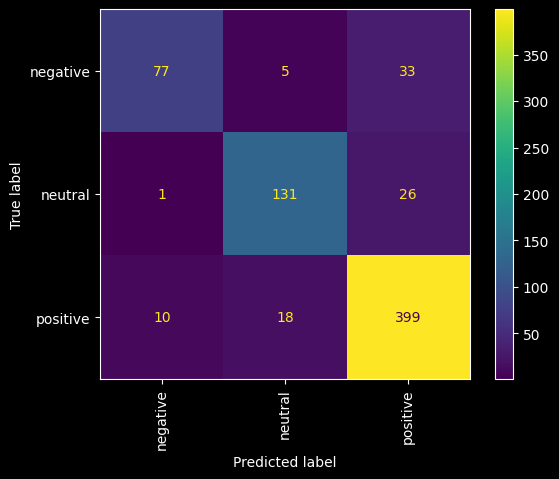

In [35]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = label_encoder.classes_)
disp.plot(cmap='viridis',
          xticks_rotation='vertical')

#Conclusion

This improvement in recall for the negative class from 55% to 68% indicates that the model has become better at identifying negative instances. However, it is still the weakest point of the model, especially when compared to the performance for the positive and neutral classes, which demonstrate higher precision and recall values.

Given that the primary goal is sentiment analysis in news, this limitation may not be critical, as positive and neutral sentiments likely represent the majority of the data. However, for applications where accurate detection of negative sentiment is crucial